In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
import requests
import seaborn as sns

%matplotlib inline

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(8, 6))

# Basic analysis

In [2]:
nsc1_participant_extended = pd.read_csv('data/processed/nsc1_participant_extended.csv', 
                                        na_values='Nan', 
                                        dtype={'PostalCode': str})
nsc1_participant_extended.head(1)

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance  sum  mean  std  median  amin  amax  no_of_active_days last_day first_day  lifespan
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==  1.382268  103.895279  34895.401134  40469.814863         228.666457              249.606197     698.343814  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN

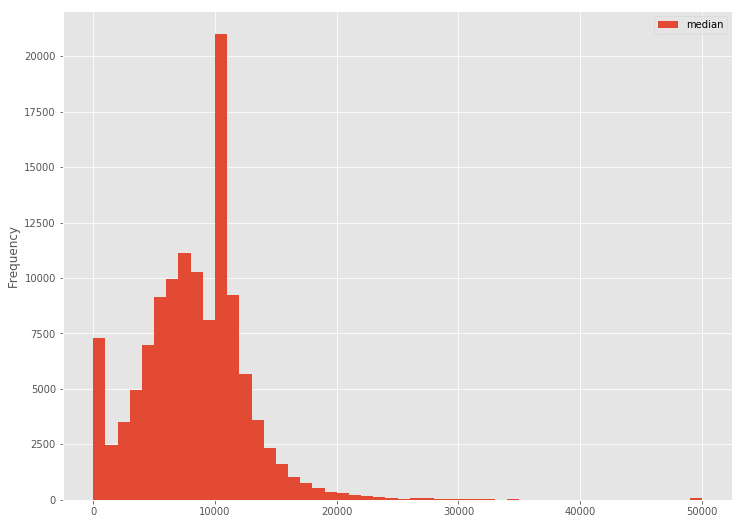

In [26]:
nsc1_participant_extended[['median']].plot.hist(bins=50)

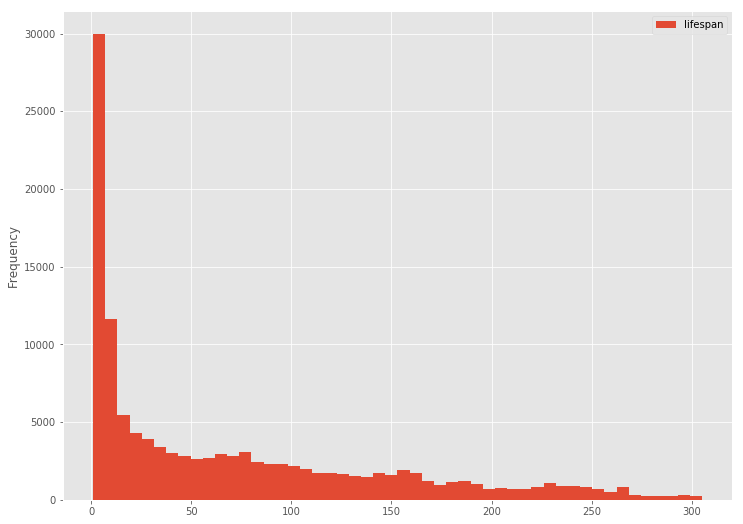

In [27]:
nsc1_participant_extended[['lifespan']].plot.hist(bins=50)

# Distance to public services

In [26]:
# Filter out those who have location data
participant_with_loc = nsc1_participant_extended[nsc1_participant_extended['x'].notnull()]

In [27]:
(len(participant_with_loc), len(nsc1_participant_extended))

(151234, 183808)

## Bus stop

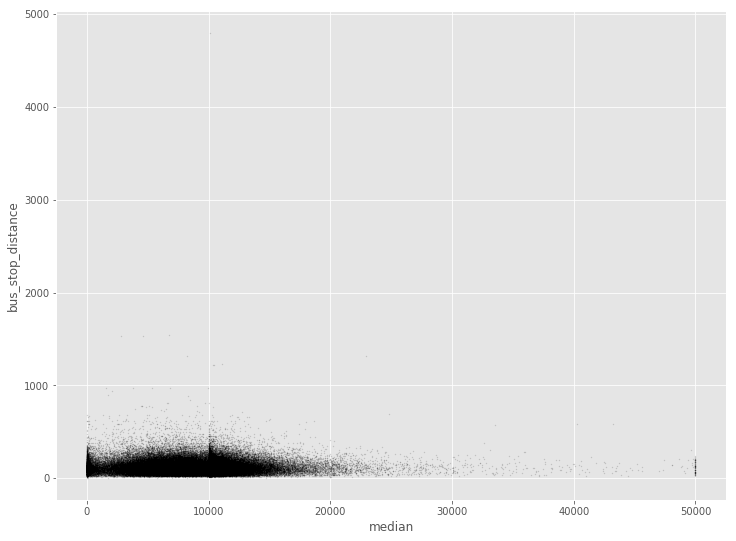

In [28]:
participant_with_loc[['median', 'bus_stop_distance']] \
.plot\
.scatter(y='bus_stop_distance', 
         x='median', 
         alpha=0.1,
         s=1,
         color='black')

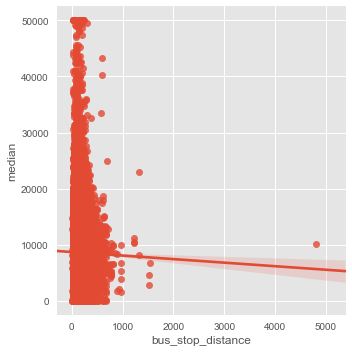

In [34]:
sns.lmplot(x='bus_stop_distance', y='median',data=participant_with_loc[['median', 'bus_stop_distance']],fit_reg=True) 

## Train station

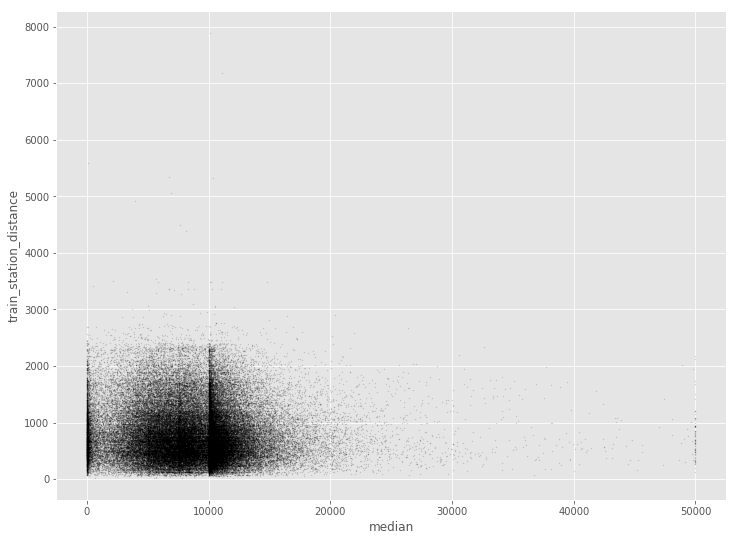

In [29]:
participant_with_loc[['median', 'train_station_distance']]\
.plot.scatter(y='train_station_distance', x='median', alpha=0.1, s=1, color='black')

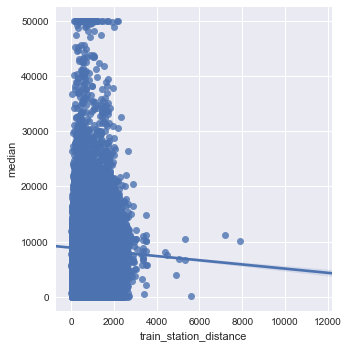

In [31]:
sns.lmplot(x='train_station_distance', y='median',data=participant_with_loc[['median', 'train_station_distance']],fit_reg=True) 

## Park

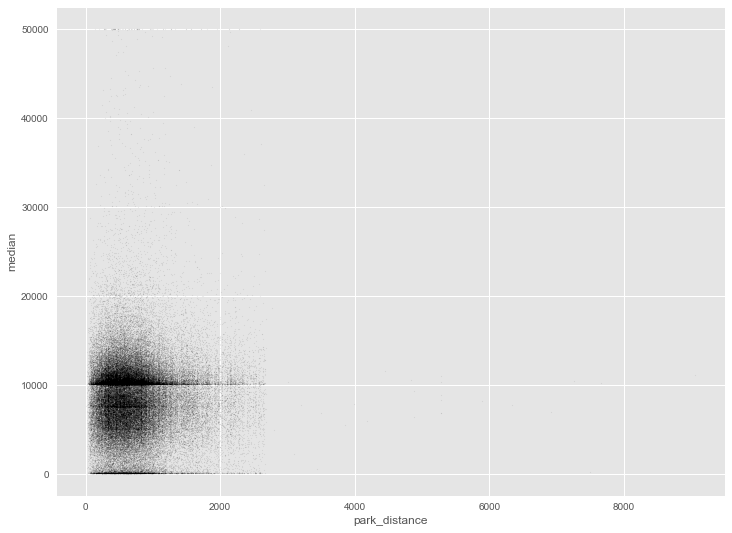

In [36]:
participant_with_loc[['median', 'park_distance']]\
.plot.scatter(x='park_distance', y='median', alpha=0.05, s=0.5, color='black')

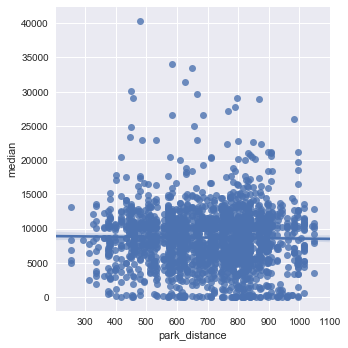

In [32]:
sns.lmplot(x='park_distance', y='median',data=nsc1_participant_extended_filtered[['median', 'park_distance']],fit_reg=True) 

## Mall analysis

In [4]:
from svy21 import SVY21

conv = SVY21()
conv.computeSVY21(1.43611, 103.78583)

(46423.393060147064, 22715.281505867424)

In [5]:
# Use Jurong Point as a reference mall, get all postal code with in 1000 m and their distance to mall
postgis_con = pg.connect(database='postgres', user='postgres', host='localhost')
distance_to_mall_sql = "SELECT postalcode, st_distance(geoloc, ST_GeomFromText('POINT(' || '46423.393060147064' || ' ' || '22715.281505867424' || ')')) as distance FROM postal_code WHERE st_distance(geoloc, ST_GeomFromText('POINT(' || '13907.049476' || ' ' || '35746.0836332' || ')')) < 1000;"
mall_distance = pd.read_sql(distance_to_mall_sql, con=postgis_con)
# park_distance = park_distance.rename(columns={'distance': 'park_distance'})
mall_distance.head()

postalcode      distance
0     629795  35029.471783
1     629816  34830.375041
2     640179  35111.139323
3     640167  35366.698473
4     640168  35376.019186

In [22]:
nsc1_participant_extended_filtered = nsc1_participant_extended[nsc1_participant_extended.PostalCode.isin(mall_distance.postalcode.values)]

In [23]:
nsc1_participant_extended_filtered = nsc1_participant_extended_filtered.join(mall_distance.set_index('postalcode'), on='PostalCode')

In [24]:
nsc1_participant_extended_filtered.head()

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt                    WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance       sum    mean          std  median    amin     amax  no_of_active_days    last_day   first_day  lifespan      distance
15   1114717          1                                                NaN      M     641674      58     165              0                 180                 0            0               0      2.0.1        asus        K00Y            0  25NOV15:19:56:48  25NOV15:20:03:29                           NaN                NaN                NaN          58.0  wRx8r4M/aehC1rlRWDy+kw==  1.344461  103.702315  13420.754243  36289.611114          97.429060              770.112840     820.594629       NaN     NaN          NaN     NaN     NaN      NaN                NaN         NaN         NaN       NaN  35685.243354
40   1088427          1  44c258b34ccb6e4a97e269cf1394f5b6c9538fa62f5f28...      F     640178      65     155              0                 240                 0            0               0      2.1.7       apple   iPhone7;1            0  18NOV15:22:19:03  09MAY16:10:04:57  1448096909796377151121170829   21NOV15:17:08:29                NaN          60.0  smb4poeYZTpCK5W/EeVHHg==  1.347312  103.708804  14142.908653  36604.836031         169.481677             1010.233852     994.101455   42072.0  5259.0  3408.206105  6463.0    50.0   9860.0                8.0  2015-11-22  2015-11-12      11.0  35141.846828
364  1198514          1  bd15f5851590841cac405a2e6a7906890a24bde9b31ba5...      F     643668      68     160              0                  60                 0            0               0      2.1.1       apple   iPhone7;1            0  22DEC15:23:36:14  22DEC15:23:47:46  1450799192393117151222234632   22DEC15:23:46:34                NaN          62.0  25wNyD9ayULvU6+3R3j9eQ==  1.341333  103.703404  13541.898397  35943.670942         100.209629              422.322971     618.090892   78704.0  9838.0  4544.285391  9584.5  2518.0  15316.0                8.0  2015-12-22  2015-12-15       8.0  35442.671716
420  1236685          1  705b2dc6c0105d1ebdfe71bed74c3d785f1e23dcb1df72...      M     641672      85     175              0                  60                 0            0               0      2.1.7       apple   iPhone7;1            0  25JAN16:12:13:21  15JUN16:21:34:54                           NaN                NaN                NaN          79.0  3/uMHMohOVIFIQXIlIjBvg==  1.343725  103.700939  13267.601393  36208.170745         128.130786              789.330867     889.914625  163790.0  7445.0  5375.864856  6764.0    17.0  17458.0               22.0  2016-02-16  2016-01-18      30.0  35796.153160
516  1118401          1  APA91bHD6YW-Kq3129CJXApCRy4oA1RzO_DTmTvDXGcJxG...      M     643684       0       0              0                 100                 0            0               0      2.0.2        Sony       E6653            0  26NOV15:13:07:28  24JAN16:10:52:12                           NaN                NaN                NaN           0.0  sHOvjdA9qNnnizomLcHRWQ==  1.343587  103.704503  13664.216102  36192.873094         127.791993              577.524487     721.175222       NaN     NaN          NaN     NaN     NaN      NaN                NaN         NaN         NaN       NaN  35423.285421

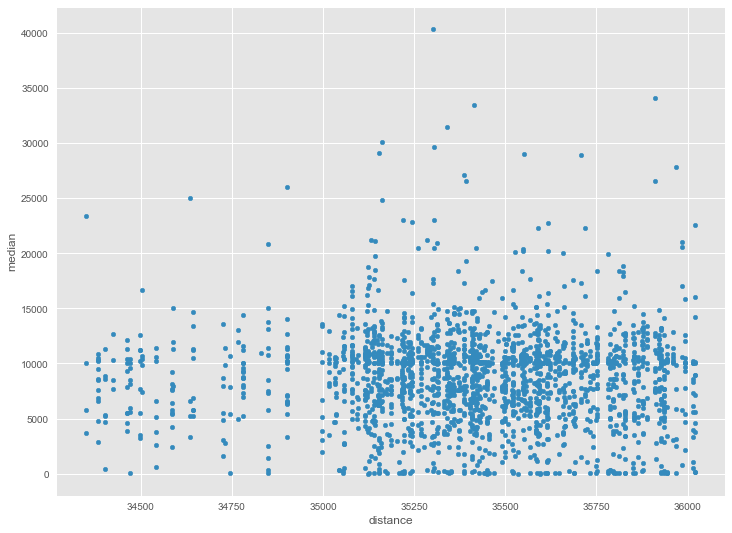

In [25]:
nsc1_participant_extended_filtered[['median', 'distance']].plot.scatter(x='distance', y='median')

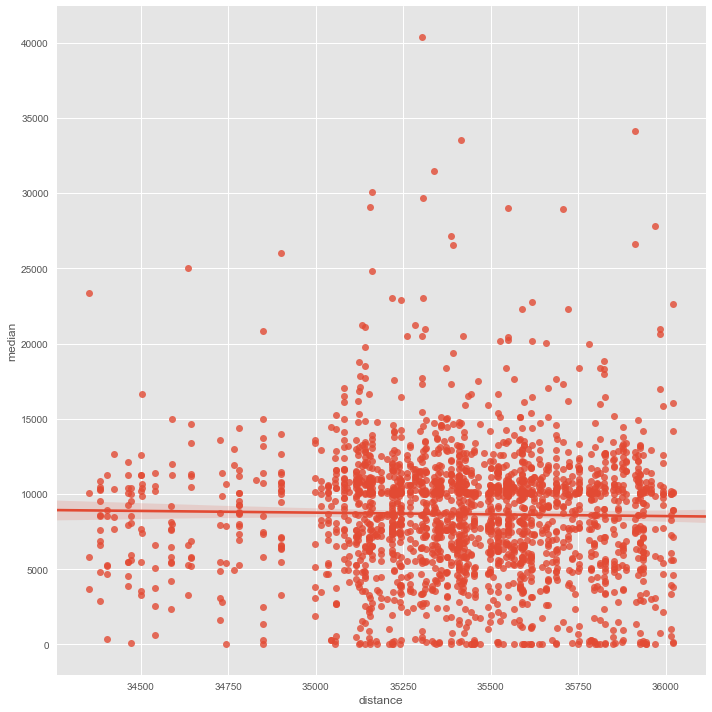

In [27]:
import seaborn as sns
sns.lmplot(x='distance', y='median',size=10,data=nsc1_participant_extended_filtered[['median', 'distance']],fit_reg=True) 

In [11]:
conv.computeSVY21(1.303956, 103.9263725)

(31810.61265695804, 38356.092215939054)

In [12]:
distance_to_park_sql = "SELECT postalcode, st_distance(geoloc, ST_GeomFromText('POINT(' || '31810.61265695804' || ' ' || '38356.092215939054' || ')')) as distance FROM postal_code WHERE st_distance(geoloc, ST_GeomFromText('POINT(' || '13907.049476' || ' ' || '35746.0836332' || ')')) < 1000;"
park_distance = pd.read_sql(distance_to_park_sql, con=postgis_con)
# park_distance = park_distance.rename(columns={'distance': 'park_distance'})
park_distance.head()

postalcode      distance
0     629795  18487.390569
1     629816  18221.982991
2     640179  17737.266948
3     640167  18033.733058
4     640168  18029.839221

In [28]:
nsc1_participant_extended_filtered = nsc1_participant_extended[nsc1_participant_extended.PostalCode.isin(park_distance.postalcode.values)]

In [29]:
nsc1_participant_extended_filtered = nsc1_participant_extended_filtered.join(mall_distance.set_index('postalcode'), on='PostalCode')

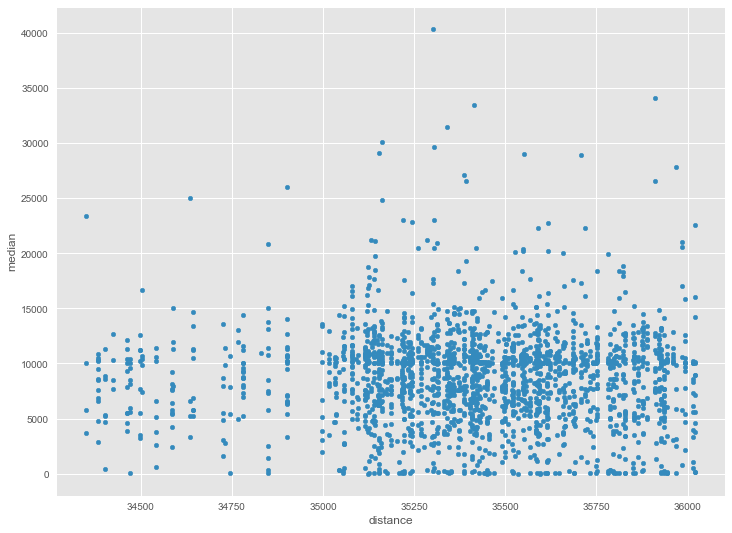

In [30]:
nsc1_participant_extended_filtered[['median', 'distance']].plot.scatter(x='distance', y='median')

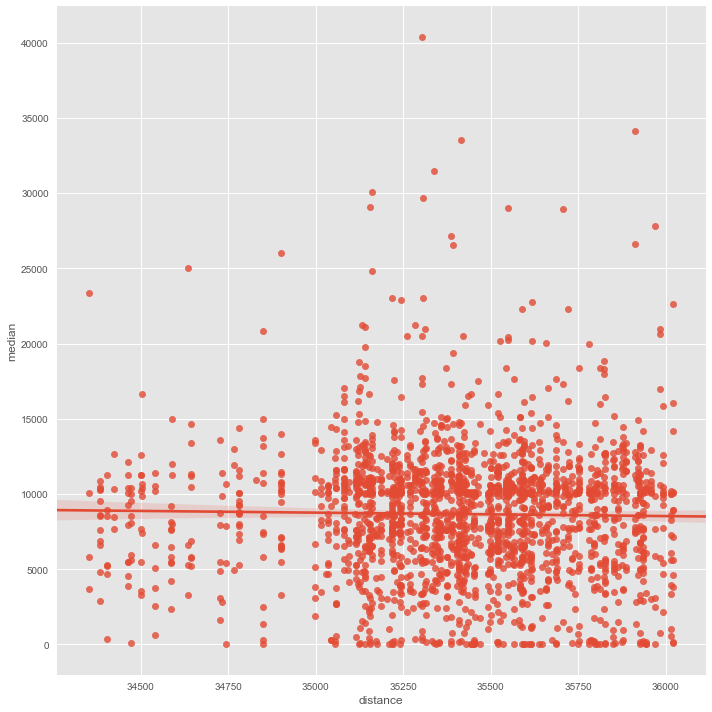

In [31]:
sns.lmplot(x='distance', y='median', size=10, 
           data=nsc1_participant_extended_filtered[['median', 'distance']], 
           fit_reg=True) 

# Location analysis

In [276]:
# filter out thos who have extremelly amount of steps 50000
# participant_with_loc_filtered = participant_with_loc[participant_with_loc['median'] < 40000]

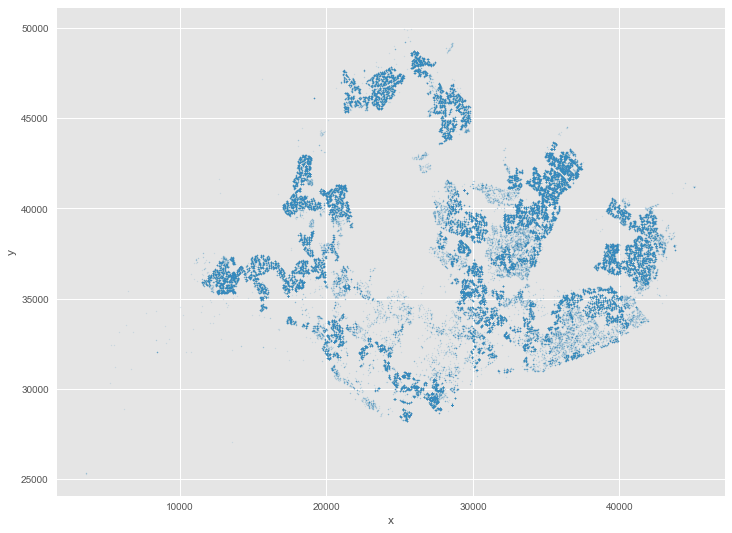

In [37]:
participant_with_loc[['x', 'y', 'median']].plot.scatter(x='x', y='y', alpha=0.1, s=1)

In [35]:
postal_code_num_people = participant_with_loc[['PostalCode', 'Id']].groupby('PostalCode').agg('count')
postal_code_num_people.head(1)

Id
PostalCode    
100044      25

In [280]:
postal_code_num_people = postal_code_num_people.join(postal_code_com)

In [287]:
postal_code_num_people = postal_code_num_people[postal_code_num_people.x.notnull()]

In [291]:
postal_code_num_people = postal_code_num_people.rename(columns={'long': 'lon'})

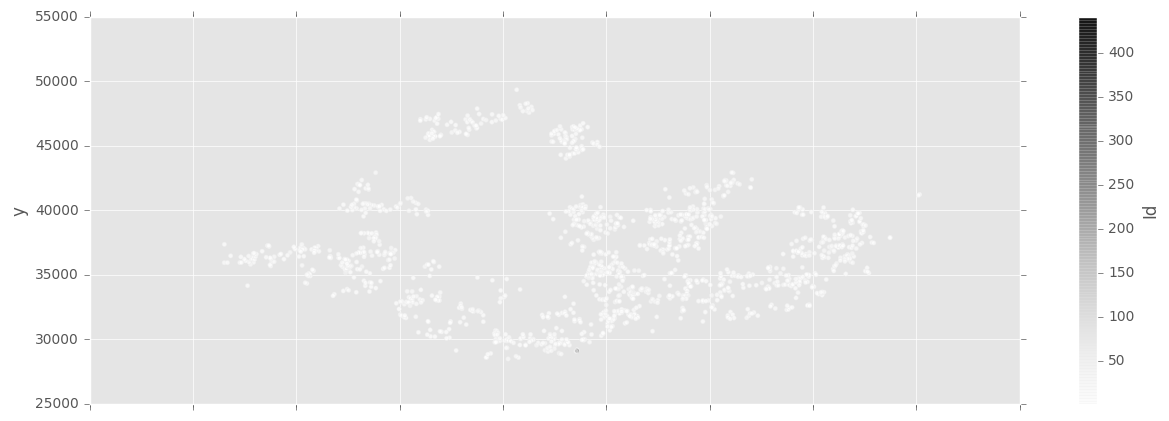

In [289]:
plt.set_cmap
postal_code_num_people[['x', 'y', 'Id']].plot.scatter(x='x', y='y', c='Id', alpha=0.7, s=10)

In [292]:
postal_code_num_people[['lat', 'lon', 'Id']].to_csv('data/processed/postalcode_participant_count.csv', index=False)